In [ ]:
# installing transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.4 MB/s eta 0:00:00


In [ ]:
# importing required libraries
import requests
import json
import torch
import os
from tqdm import tqdm
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader
from transformers import BertForQuestionAnswering
from transformers import AdamW
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the training dataset and take a look at it
with open('/content/drive/MyDrive/train.json', 'rb') as f:
  train= json.load(f)

In [ ]:
# Load the training dataset and take a look at it
with open('/content/drive/MyDrive/test.json', 'rb') as f:
  valid= json.load(f)

In [ ]:
# Each 'data' dict has two keys (title and paragraphs)
train['data'][0].keys()

dict_keys(['paragraphs'])

In [ ]:
train['data'][0]

{'paragraphs': [{'qas': [{'question': 'In which state is Los Angeles?',
     'id': 597553,
     'answers': [{'answer_id': 647225,
       'document_id': 1202512,
       'question_id': 597553,
       'text': 'California',
       'answer_start': 36,
       'answer_end': 46,
       'answer_category': None}],
     'is_impossible': False},
    {'question': 'What more can be told about the city?',
     'id': 597555,
     'answers': [{'answer_id': 647227,
       'document_id': 1202512,
       'question_id': 597555,
       'text': 'TCL Chinese Theatre displays celebrities’ hand- and footprints, the Walk of Fame honors thousands of luminaries and vendors sell maps to stars’ homes',
       'answer_start': 266,
       'answer_end': 415,
       'answer_category': None}],
     'is_impossible': False},
    {'question': 'What are some iconic thing about the city?',
     'id': 597559,
     'answers': [{'answer_id': 647232,
       'document_id': 1202512,
       'question_id': 597559,
       'text': 'Par

As we can see each row contains a key "qas" which contains all the information about the annotated answers and another key "context" which contains the data which is used for annotation. 

In [ ]:
len(train['data'])

120

In [ ]:
len(valid['data'])

30

In [ ]:
#Converting the Squad data into df for visualization.
p = []
q=[]
ans = []
astart = []
aend= []
for i in train["data"]:
    for j in i["paragraphs"][0]["qas"]:
        #print(j)
        if(len(j["answers"])!=0):
          astart.append(j["answers"][0]["answer_start"])

          p.append(i["paragraphs"][0]["context"])
          q.append(j["question"])
          
          ans.append(j["answers"][0]["text"])
          aend.append(j["answers"][0]["answer_end"])
        
df = pd.DataFrame()
df["context"] = p
df["questions"] = q
df["answer"] = ans
df["answer_start"] = astart
df["answer_end"] = aend

In [ ]:
df

,context,questions,answer,answer_start,answer_end
0,Los Angeles is a sprawling Southern California...,In which state is Los Angeles?,California,36,46
1,Los Angeles is a sprawling Southern California...,What more can be told about the city?,TCL Chinese Theatre displays celebrities’ hand...,266,415
2,Los Angeles is a sprawling Southern California...,What are some iconic thing about the city?,"Paramount Pictures, Universal and Warner Brothers",161,210
3,New York City comprises 5 boroughs sitting whe...,What are some iconic thing about the city?,Empire State Building and sprawling Central Park,269,318
4,New York City comprises 5 boroughs sitting whe...,What could be said the geography of the city?,comprises 5 boroughs sitting where the Hudson ...,14,90
...,...,...,...,...,...
412,Akron is a city in Ohio. It’s home to Stan Hyw...,Where is the city located?,Akron is a city in Ohio,0,23
413,Akron is a city in Ohio. It’s home to Stan Hyw...,What are the popular landmarks in this city?,"The Akron Art Museum displays modern pieces, i...",140,416
414,Akron is a city in Ohio. It’s home to Stan Hyw...,What is this city known for?,"It’s home to Stan Hywet Hall and Gardens, wit...",24,138
415,Overland Park is the second-most populous city...,Where is the city located?,"Located in Johnson County, Kansas",75,109


In [ ]:
# loading the data in triplets of context, questions and answers
def read_data(path):  
  
  with open(path, 'rb') as f:
    squad = json.load(f)

  contexts = []
  questions = []
  answers = []

  for group in squad['data']:
    for passage in group['paragraphs']:
      context = passage['context']
      for qa in passage['qas']:
        question = qa['question']
        for answer in qa['answers']:
          contexts.append(context)
          questions.append(question)
          answers.append(answer)
  return contexts, questions, answers

In [ ]:
#calling the read_data function
train_contexts, train_questions, train_answers = read_data('/content/drive/MyDrive/train.json')
valid_contexts, valid_questions, valid_answers = read_data('/content/drive/MyDrive/test.json')

In [ ]:
train_answers

[{'answer_id': 647225,
  'document_id': 1202512,
  'question_id': 597553,
  'text': 'California',
  'answer_start': 36,
  'answer_end': 46,
  'answer_category': None},
 {'answer_id': 647227,
  'document_id': 1202512,
  'question_id': 597555,
  'text': 'TCL Chinese Theatre displays celebrities’ hand- and footprints, the Walk of Fame honors thousands of luminaries and vendors sell maps to stars’ homes',
  'answer_start': 266,
  'answer_end': 415,
  'answer_category': None},
 {'answer_id': 647232,
  'document_id': 1202512,
  'question_id': 597559,
  'text': 'Paramount Pictures, Universal and Warner Brothers',
  'answer_start': 161,
  'answer_end': 210,
  'answer_category': None},
 {'answer_id': 647231,
  'document_id': 1202511,
  'question_id': 597559,
  'text': ' Empire State Building and sprawling Central Park',
  'answer_start': 269,
  'answer_end': 318,
  'answer_category': None},
 {'answer_id': 650227,
  'document_id': 1202511,
  'question_id': 598541,
  'text': 'comprises 5 boroughs

In [ ]:
print(f'There are {len(train_questions)} train questions')
print(f'There are {len(valid_questions)} dev questions')

There are 417 train questions
There are 81 dev questions


In [ ]:
def add_end_idx(answers, contexts):
  for answer, context in zip(answers, contexts):
    gold_text = answer['text']
    start_idx = answer['answer_start']
    end_idx = start_idx + len(gold_text)

    # sometimes squad answers are off by a character or two so we fix this
    if context[start_idx:end_idx] == gold_text:
      answer['answer_end'] = end_idx
    elif context[start_idx-1:end_idx-1] == gold_text:
      answer['answer_start'] = start_idx - 1
      answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
    elif context[start_idx-2:end_idx-2] == gold_text:
      answer['answer_start'] = start_idx - 2
      answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts)
add_end_idx(valid_answers, valid_contexts)

# Visualization

In [ ]:
#Importing the required libraries for visualization
from itertools import chain
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
#from sklearn.model_selection import train_test_split

In [ ]:
allwords = " ".join(df["answer"])

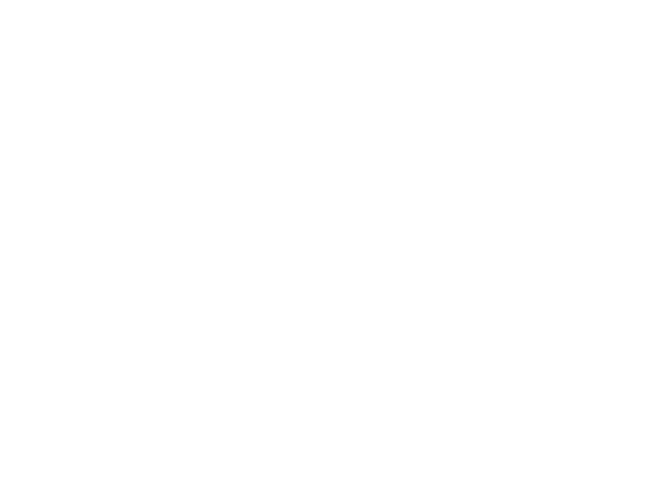

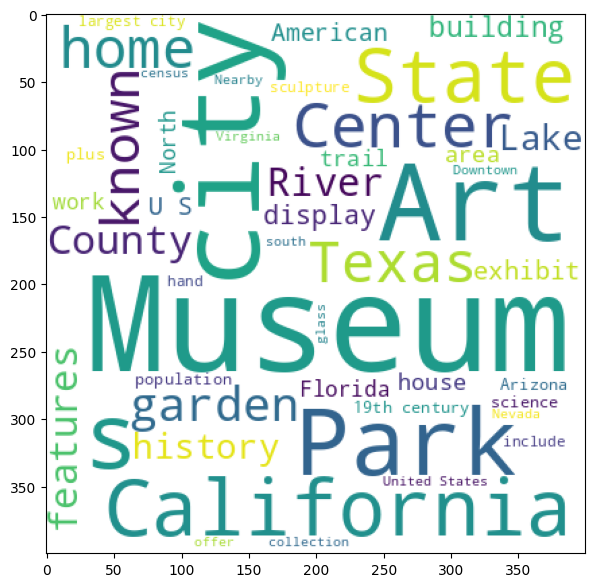

In [ ]:
wordcloud = WordCloud(width = 400, height = 400, 
                    background_color ='white', 
                    stopwords = set(STOPWORDS), 
                    min_font_size = 10).generate(allwords)

plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.figure(figsize = (7, 7), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud) 

plt.show()

As we can see there are few words like Museums, county and park are repeated many times. We can make use of these words while annotating the data and ask questions on these.

In [ ]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df["questions"])
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()
vec_df = pd.DataFrame(denselist, columns=feature_names)

In [ ]:
vec_df

,about,also,ana,anaheim,anchorage,and,angeles,any,anything,architecture,...,toledo,usa,vegas,we,what,when,where,which,wichita,you
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.627364,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.267545,0.0,0.0
1,0.245142,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.133172,0.0,0.000000,0.000000,0.0,0.0
2,0.407985,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.221636,0.0,0.000000,0.000000,0.0,0.0
3,0.407985,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.221636,0.0,0.000000,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.154266,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.643426,0.000000,0.0,0.0
413,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.186231,0.0,0.000000,0.000000,0.0,0.0
414,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.265220,0.0,0.000000,0.000000,0.0,0.0
415,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.643426,0.000000,0.0,0.0


In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nltk.download('omw-1.4')

/bin/bash: -c: line 0: syntax error near unexpected token `'omw-1.4''
/bin/bash: -c: line 0: `nltk.download('omw-1.4')'


In [ ]:
from nltk import everygrams
from nltk.corpus import stopwords
import re
from nltk.corpus import wordnet as wn
from nltk.stem.snowball import SnowballStemmer as snowball_stemmer


def clean_text_function2(text):
    t = text #contractions.fix(text)
    t= t.lower().split()#lower case
    t = [(re.sub(r'[^a-z ]', '', ch)) for ch in t]#remove everything other than a-z
    #t=[word for word in t if word not in stopword]#removing stop words
    t= [wn.lemmatize(word) for word in t]
    t=[snowball_stemmer.stem(word) for word in t]
    t=(' ').join(t)
    t=list(everygrams(t.split(), 2, 3))
    return t

In [ ]:
# clean_text_function2(df['context'][0])
a=df["context"][0]
a

'Los Angeles is a sprawling Southern California city and the center of the nation’s film and television industry. Near its iconic Hollywood sign, studios such as Paramount Pictures, Universal and Warner Brothers offer behind-the-scenes tours. On Hollywood Boulevard, TCL Chinese Theatre displays celebrities’ hand- and footprints, the Walk of Fame honors thousands of luminaries and vendors sell maps to stars’ homes'

In [ ]:
s = a.split()

In [ ]:
words = []
for i in df["context"].unique():
  s=i.split()
  words = [*words, *s]

In [ ]:
# STOPWORDS
import nltk

In [ ]:
df_bigram = pd.DataFrame()
df_bigram2 = pd.Series(nltk.ngrams(words, 2)).value_counts()
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())
bigrams = list(bigrams_series.index)
print(len(bigrams))
clean = []
flag = 0
for gram in bigrams:
  for stop in STOPWORDS:
    if stop in gram:
      # print(stop,gram)
      bigrams.remove(gram)
      flag = 1
      break
    flag = 0
  if flag == 0:
    clean.append(gram)
  

# clean = [gram for gram in bigrams if not any(stop in bigrams for stop in STOPWORDS)]
print(clean[:10])
print(len(clean))

5682
[('populous', 'city'), ('U.S.', 'state'), ('largest', 'city'), ('2020', 'census,'), ('statistical', 'area'), ('Las', 'Vegas'), ('art', 'deco'), ('hands-on', 'science'), ('interactive', 'exhibits'), ('The', "city's")]
2269


In [ ]:
bigram_series_2 = bigrams_series.loc[clean]

<Axes: >

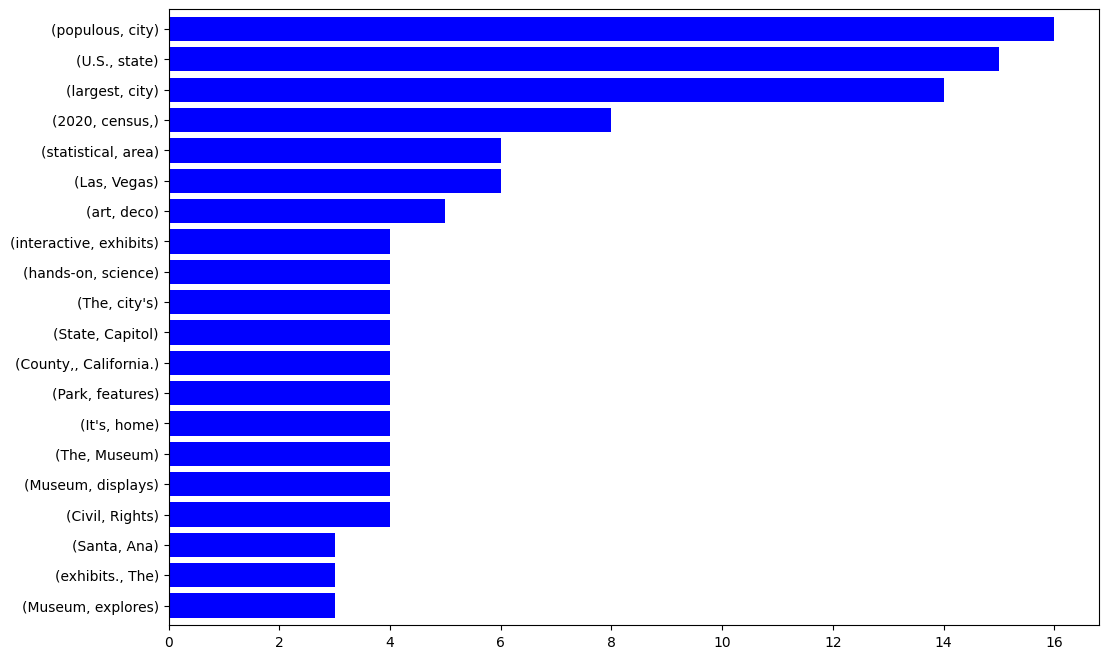

In [ ]:
bigram_series_2[:20].sort_values().plot.barh(color='blue', width=0.8, figsize=(12,8))

The bigrams as we can see shows the two words which appear next to each other. This we can use while annotating the answers for questions.

Tokenizing the data

In [ ]:
# getting the model and its tokenizer (currently training on few rows as it is very time consuming)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
valid_encodings = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True)

In [ ]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

Visualing the output of tokenizer, input ids are the token indices with padding of 0s, token_type_ids are different integers for different sequences and attention mask states which positions to give attention to while training

In [ ]:
train_encodings["input_ids"][0]

[101,
 3050,
 3349,
 2003,
 1037,
 24199,
 2670,
 2662,
 2103,
 1998,
 1996,
 2415,
 1997,
 1996,
 3842,
 1521,
 1055,
 2143,
 1998,
 2547,
 3068,
 1012,
 2379,
 2049,
 14430,
 5365,
 3696,
 1010,
 4835,
 2107,
 2004,
 11734,
 4620,
 1010,
 5415,
 1998,
 6654,
 3428,
 3749,
 2369,
 1011,
 1996,
 1011,
 5019,
 7562,
 1012,
 2006,
 5365,
 8459,
 1010,
 22975,
 2140,
 2822,
 3004,
 8834,
 12330,
 1521,
 2192,
 1011,
 1998,
 24629,
 1010,
 1996,
 3328,
 1997,
 4476,
 7836,
 5190,
 1997,
 11320,
 22311,
 5134,
 1998,
 17088,
 5271,
 7341,
 2000,
 3340,
 1521,
 5014,
 102,
 1999,
 2029,
 2110,
 2003,
 3050,
 3349,
 1029,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,

In [ ]:
train_encodings["token_type_ids"][0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
train_encodings["attention_mask"][0]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
# printing the number of training data
no_of_encodings = len(train_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 417 context-question pairs


In [ ]:
# adding the answers in the training set for fine tuning
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []
  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
    if end_positions[-1] is None:
      end_positions[-1] = tokenizer.model_max_length

  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(valid_encodings, valid_answers)

In [ ]:
# creating the dataset in the format it is required for fine tuning BERT
class SQuAD_Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings
  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  def __len__(self):
    return len(self.encodings.input_ids)

In [ ]:
train_dataset = SQuAD_Dataset(train_encodings)
valid_dataset = SQuAD_Dataset(valid_encodings)

In [ ]:
# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)

In [ ]:
# loading the BERT model which we will fine tune
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [ ]:
# checking the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

Working on cuda


In [ ]:
# Fine tuning it per batch
N_EPOCHS = 5
optim = AdamW(model.parameters(), lr=5e-5)

model.to(device)
model.train()

for epoch in range(N_EPOCHS):
  loop = tqdm(train_loader, leave=True)
  for batch in loop:
    optim.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    loss.backward()
    optim.step()

    loop.set_description(f'Epoch {epoch+1}')
    loop.set_postfix(loss=loss.item())

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5: 100%|██████████| 53/53 [00:16<00:00,  3.19it/s, loss=1.5]


In [ ]:
# checking the performance
model.eval()

acc = []

for batch in tqdm(valid_loader):
  with torch.no_grad():
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_true = batch['start_positions'].to(device)
    end_true = batch['end_positions'].to(device)
    
    outputs = model(input_ids, attention_mask=attention_mask)

    start_pred = torch.argmax(outputs['start_logits'], dim=1)
    end_pred = torch.argmax(outputs['end_logits'], dim=1)

    acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
    acc.append(((end_pred == end_true).sum()/len(end_pred)).item())

acc = sum(acc)/len(acc)

100%|██████████| 11/11 [00:00<00:00, 17.48it/s]


In [ ]:
acc

0.29545454545454547